In [1]:
# Chapter 17 Dimension Reduction
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)


X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [3]:
ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## PCA

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    StandardScaler,
)
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(X)
)
pca.explained_variance_ratio_
pca.components_[0]

array([-0.63274156,  0.39602149,  0.00653646,  0.11500362,  0.5815031 ,
       -0.19764926, -0.20422289, -0.10304598])

[(0, 1),
 Text(0,0.5,'Percent of Explained variance'),
 Text(0.5,0,'Component'),
 Text(0.5,1,'Scree Plot')]

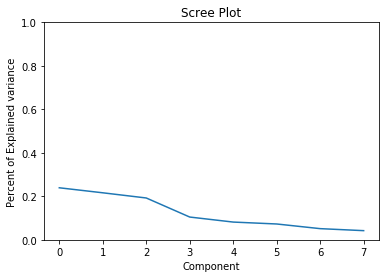

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pca.explained_variance_ratio_)
ax.set(
    xlabel="Component",
    ylabel="Percent of Explained variance",
    title="Scree Plot",
    ylim=(0, 1),
)
# fig.savefig(
#     "images/mlpr_1701.png",
#     dpi=300,
#     bbox_inches="tight",
# )

[(0, 1),
 Text(0,0.5,'Percent of Explained variance'),
 Text(0.5,0,'Component'),
 Text(0.5,1,'Cumulative Variance')]

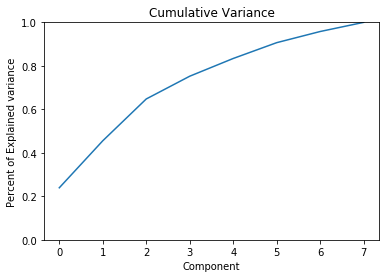

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    np.cumsum(pca.explained_variance_ratio_)
)
ax.set(
    xlabel="Component",
    ylabel="Percent of Explained variance",
    title="Cumulative Variance",
    ylim=(0, 1),
)
#fig.savefig("images/mlpr_1702.png", dpi=300)

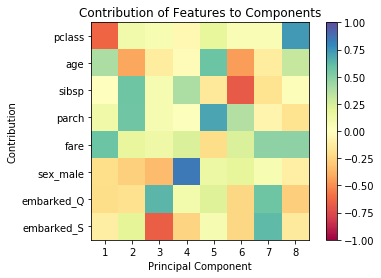

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.imshow(
    pca.components_.T,
    cmap="Spectral",
    vmin=-1,
    vmax=1,
)
plt.yticks(range(len(X.columns)), X.columns)
plt.xticks(range(8), range(1, 9))
plt.xlabel("Principal Component")
plt.ylabel("Contribution")
plt.title(
    "Contribution of Features to Components"
)
plt.colorbar()
#fig.savefig("images/mlpr_1703.png", dpi=300)

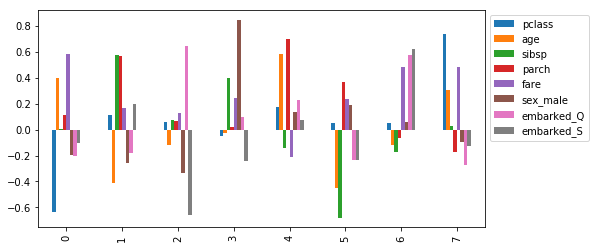

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
pd.DataFrame(
    pca.components_, columns=X.columns
).plot(kind="bar", ax=ax).legend(
    bbox_to_anchor=(1, 1)
)
#fig.savefig("images/mlpr_1704.png", dpi=300)

In [9]:
comps = pd.DataFrame(
    pca.components_, columns=X.columns
)
min_val = 0.5
num_components = 2
pca_cols = set()
for i in range(num_components):
    parts = comps.iloc[i][
        comps.iloc[i].abs() > min_val
    ]
    pca_cols.update(set(parts.index))
pca_cols

{'fare', 'parch', 'pclass', 'sibsp'}